<a href="https://colab.research.google.com/github/cverluise/PatCit/blob/nightly/intext_patent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files
import matplotlib.pyplot as plt

# Set up

> If you don't have the JSON file that contains your key yet, follow the instructions to [create a service account](https://cloud.google.com/docs/authentication/getting-started#creating_a_service_account)

In [2]:
# Upload your credentials
uploaded = files.upload() 

Saving npl-parsing-3412b4cafd20.json to npl-parsing-3412b4cafd20.json


In [3]:
key_path = "./npl-parsing-3412b4cafd20.json" # change the name to match your credentials file name

In [4]:
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [5]:
intext_patent_table="patcit-public-data.intext.patent"

In [6]:
FIGSIZE=(12,9)

## Nb patents with at least one in-text patent citation

In [ ]:
query = f"""
WITH
  tmp AS(
  SELECT
    CAST(p.publication_date/10000 AS INT64) AS publication_year,
    COUNT(DISTINCT(p.publication_number)) AS nb_patents_with_intext_cit,
  FROM
    `{intext_patent_table}` AS p,
    UNNEST(citation) AS citation
  WHERE
    citation.country_code IS NOT NULL
    AND citation.original_number IS NOT NULL
  GROUP BY
    publication_year)
SELECT
  tmp.publication_year,
  tmp.nb_patents_with_intext_cit,
  p.nb_patents
FROM
  tmp
JOIN (
  SELECT
    CAST(p.publication_date/10000 AS INT64) AS publication_year,
    COUNT(DISTINCT(publication_number)) AS nb_patents
  FROM
    `{intext_patent_table}` AS p
  GROUP BY
    publication_year) AS p
ON
  tmp.publication_year = p.publication_year"""

In [ ]:
tmp = client.query(query).to_dataframe()

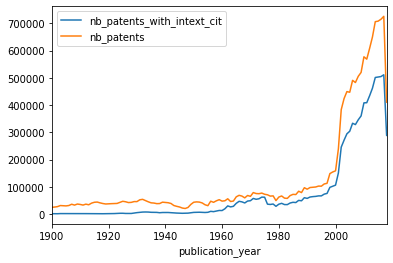

In [ ]:
tmp.sort_values("publication_year").set_index("publication_year").plot(xlim=(1900,2018));

## Nb in-text patent citations detected

In [7]:
query = f"""
SELECT
  CAST(p.publication_date/10000 AS INT64) AS publication_year,
  COUNT(CONCAT(citation.country_code, citation.original_number)) AS nb_intext_patent_citations
FROM
  `{intext_patent_table}` AS p,
  UNNEST(citation) AS citation
GROUP BY
  publication_year
ORDER BY publication_year ASC"""

In [8]:
tmp = client.query(query).to_dataframe()

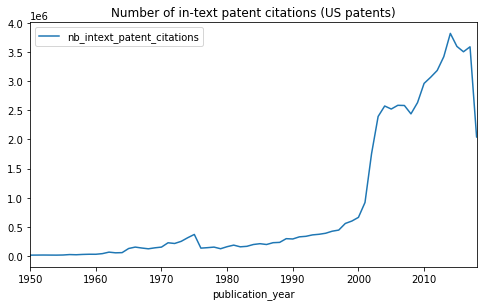

In [9]:
tmp.set_index("publication_year").plot(xlim=(1950, 2018), 
                                       figsize=FIGSIZE,
                                       title="Number of in-text patent citations (US patents)");

## Overlap with front-page patent citations

In [60]:
query = f"""WITH
  tmp AS (
  WITH
    prime AS (
    WITH
      second AS (
      SELECT
        CAST(p.publication_date/10000 AS INT64) AS publication_year,
        p.publication_number,
        citation.publication_number AS citation_pubnum,
        CONCAT(p.publication_number, "_", citation.publication_number) AS cit_uid,
        "frontpage" AS origin
      FROM
        `patents-public-data.patents.publications` AS p,
        UNNEST(citation) AS citation
      WHERE
        p.country_code="US"
        AND citation.publication_number IS NOT NULL
      UNION ALL
      SELECT
        CAST(p.publication_date/10000 AS INT64) AS publication_year,
        p.publication_number,
        citation.publication_number AS citation_pubnum,
        CONCAT(p.publication_number, "_", citation.publication_number) AS cit_uid,
        "intext" AS origin
      FROM
        `{intext_patent_table}` AS p,
        UNNEST(citation) AS citation
      WHERE
        citation.publication_number IS NOT NULL )
    SELECT
      # make sure that we do not have duplicates
      ANY_VALUE(publication_year) AS publication_year,
      ANY_VALUE(publication_number) AS publication_number,
      cit_uid,
      origin
    FROM
      second
    GROUP BY
      cit_uid,
      origin)
  SELECT
    ANY_VALUE(publication_year) AS publication_year,
    cit_uid,
    STRING_AGG(origin, "_"
    ORDER BY
      origin) AS origin
  FROM
    prime
  GROUP BY
    cit_uid )
SELECT
  publication_year,
  origin,
  COUNT(origin) AS nb_occ
FROM
  tmp
GROUP BY
  publication_year,
  origin"""

In [61]:
tmp = client.query(query).to_dataframe()

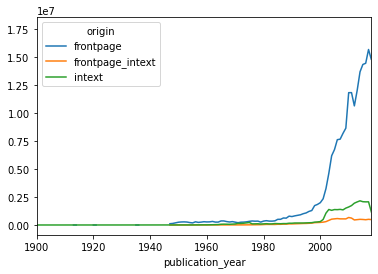

In [75]:
tmp.pivot(index="publication_year", columns="origin", values="nb_occ").plot(xlim=(1900,2018));

## Country-time in-text vs front-page citations

In [90]:
query_intext = f"""
SELECT
  CAST(p.publication_date/10000 AS INT64) AS publication_year,
  citation.country_code,
  COUNT(citation.publication_number) AS nb_cit
FROM
  `{intext_patent_table}` AS p,
  UNNEST(citation) AS citation
GROUP BY
  publication_year,
  country_code"""

In [101]:
query_frontpage = """
SELECT
  CAST(p.publication_date/10000 AS INT64) AS publication_year,
  SPLIT(citation.publication_number, "-")[OFFSET(0)] as country_code,
  COUNT(citation.publication_number) AS nb_cit
FROM
  `patents-public-data.patents.publications` AS p,
  UNNEST(citation) AS citation
WHERE
  p.country_code="US"
GROUP BY
  publication_year,
  country_code"""

In [102]:
tmp_intext = client.query(query_intext).to_dataframe()
tmp_frontpage = client.query(query_frontpage).to_dataframe()

In [103]:
tmp_intext_ = tmp_intext.pivot(index="publication_year", columns="country_code", values="nb_cit")
tmp_frontpage_ = tmp_frontpage.pivot(index="publication_year", columns="country_code", values="nb_cit")

### Nb citations by receiving office

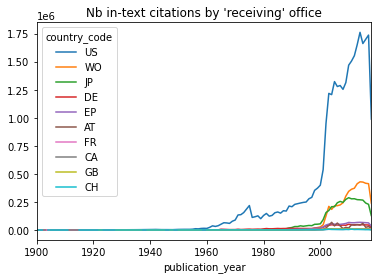

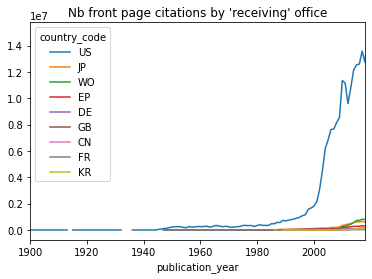

In [107]:
n = 10
topn_intext = list(tmp_intext_.sum().sort_values(ascending=False).index[:10])
topn_frontpage = list(tmp_frontpage_.sum().sort_values(ascending=False).index[:10])
topn_frontpage.remove('')

tmp_intext_[topn_intext].plot(xlim=(1900,2018), 
                              title="Nb in-text citations by 'receiving' office")
tmp_frontpage_[topn_frontpage].plot(xlim=(1900,2018),
                                    title="Nb front page citations by 'receiving' office");

### Ratio of received citations

In [28]:
intext_country_codes = set(tmp_intext_.columns)
frontpage_country_codes = set(tmp_frontpage_.columns)

In [30]:
print("Country codes intext not frontpage:", intext_country_codes - frontpage_country_codes)
print("Country codes frontpage not intext:", frontpage_country_codes - intext_country_codes)

Country codes intext not frontpage: {nan, 'IQ', 'AL', 'KP', 'IB', 'NG', 'BX', 'IR', 'DZ', 'JO', 'MN', 'VE', 'LK', 'KE', 'TH', 'RD', 'TP', 'TT', 'VN', 'MW'}
Country codes frontpage not intext: {'', 'EE', 'GT', 'GE', 'GC', 'DO', 'TJ', 'BY', 'KG', 'KZ', 'HN', 'SV', 'EC', 'RS', 'CR', 'MO'}


In [31]:
tmp_all = tmp_intext_.merge(tmp_frontpage_, left_index=True, right_index=True, suffixes=("_intext", "_frontpage"))
for cc in intext_country_codes & frontpage_country_codes:
  tmp_all[cc+"_ratio"] = tmp_all[cc+"_intext"]/tmp_all[cc+"_frontpage"]

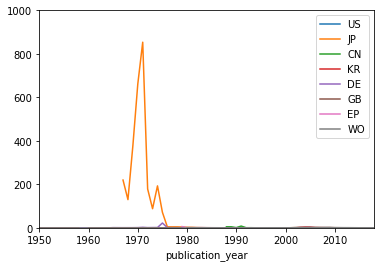

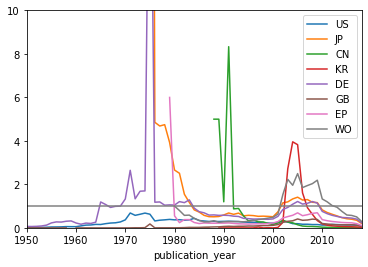

In [55]:
tmp_ratio = tmp_all.filter(regex="_ratio")
tmp_ratio.columns = [c.split("_")[0] for c in tmp_ratio.columns]

for ylim in [(0,1000), (0,10)]:
  tmp_ratio[["US","JP","CN","KR","DE","GB","EP","WO"]].plot(xlim=(1950,2018), ylim=ylim)
  plt.axhline(y=1, color="grey", linestyle="-");

Reading: in 2005, there were 4x more `KR` in the text than on the front page. 

Confirms the idea that front-page patent citations struggle to track non english citations.

> Technically, this is because they are cited as "translated patent CC-XXXXX ..." and assigned to the NPL citations section rather than the Patent citations. 